In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, matthews_corrcoef, classification_report
from sklearn.inspection import permutation_importance

# Встановлюємо стиль для графіків
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [18]:
# 1. Завантаження даних
try:
    data = pd.read_csv('global_coffee_health.csv')
except FileNotFoundError:
    print("Помилка: Файл 'global_coffee_health.csv' не знайдено.")
    print("Будь ласка, завантажте датасет і розмістіть його в тій самій папці.")
    # Зупиняємо виконання, якщо файлу немає
    # У .ipynb це можна зробити, не запускаючи наступні комірки
    assert False, "Dataset file not found"

# 2. Попередня обробка (згідно з [cite: 4])
# Видаляємо ID (неінформативний ідентифікатор)
data = data.drop('ID', axis=1)

# Визначаємо цільову змінну (y) та ознаки (X) [cite: 3, 153, 154]
TARGET_VAR = 'Health_Issues'
# Видаляємо рядки, де цільова змінна порожня або не відповідає очікуваним класам
# Залишаємо тільки 'mild', 'moderate' та 'severe'
allowed_classes = ['mild', 'moderate', 'severe']
# Видаляємо NaN у цільовій змінній
data = data[data[TARGET_VAR].notna()]
# Нормалізуємо рядкові мітки (trim + lower) на випадок варіацій форматування
data[TARGET_VAR] = data[TARGET_VAR].astype(str).str.strip().str.lower()
# Фільтруємо лише дозволені класи
data = data[data[TARGET_VAR].isin(allowed_classes)].copy()

# Оновлюємо X і y після фільтрації
X = data.drop(TARGET_VAR, axis=1)
y = data[TARGET_VAR]

# 3. Кодування категоріальних ознак [cite: 4]
# Для 'y' (цільова змінна) використовуємо LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# Збережемо назви класів для майбутньої візуалізації (приводимо до str,
# щоб sklearn.metrics.classification_report не падав, якщо метки нестрокові)
class_names = [str(c) for c in le.classes_]

# Для ознак 'X' використовуємо one-hot encoding (pd.get_dummies),
# оскільки це простий спосіб обробити номінальні дані
categorical_features = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 'Occupation', 'Smoking', 'Alcohol_Consumption']
X_processed = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Збережемо імена всіх ознак для графіків важливості
feature_names = X_processed.columns.tolist()

In [19]:
# 4. Поділ даних на тренувальну та тестову вибірки (80/20) 
X_train, X_test, y_train, y_test = train_test_split(
    X_processed.values, # Конвертуємо в numpy для нашої реалізації
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded # Важливо для збалансованого поділу класів
)

print(f"Розмір тренувальної вибірки: {X_train.shape}")
print(f"Розмір тестової вибірки: {X_test.shape}")

Розмір тренувальної вибірки: (3247, 39)
Розмір тестової вибірки: (812, 39)


In [20]:
class MyDecisionTree:
    """
    Власна реалізація дерева рішень для класифікації з використанням
    Gini Index та розрахунком важливості ознак.
    """
    def __init__(self, max_depth=5, min_samples_split=2):
        self.max_depth = max_depth  # [cite: 39]
        self.min_samples_split = min_samples_split  # [cite: 41]
        self.tree = None
        self.feature_importance = None
        self.n_total_samples = None
        self.n_features = None

    def _gini(self, y):
        """Розрахунок Gini Impurity [cite: 12, 44]"""
        if y.size == 0:
            return 0
        # Рахуємо унікальні класи та їх кількість
        _, counts = np.unique(y, return_counts=True)
        # Рахуємо ймовірності p_i
        probabilities = counts / y.size
        # Формула Gini: 1 - sum(p_i^2)
        gini = 1 - np.sum(probabilities**2)
        return gini

    def _best_split(self, X, y):
        """
        Знаходить найкращий розділ (ознаку та поріг)
        на основі мінімального зваженого Gini[cite: 15, 32, 46].
        """
        n_samples, n_features = X.shape
        if n_samples <= 1:
            return None, None, None

        # Gini батьківського вузла
        parent_gini = self._gini(y)
        best_gini_weighted = parent_gini
        best_feature_idx, best_threshold = None, None
        best_gini_reduction = 0

        for feature_idx in range(n_features): # [cite: 50]
            # Беремо унікальні значення для порогів
            thresholds = np.unique(X[:, feature_idx])

            for threshold in thresholds:
                # Розділяємо дані
                left_indices = np.where(X[:, feature_idx] <= threshold)[0]
                right_indices = np.where(X[:, feature_idx] > threshold)[0]

                # Якщо розділ неможливий, пропускаємо
                if len(left_indices) == 0 or len(right_indices) == 0:
                    continue

                y_left, y_right = y[left_indices], y[right_indices]
                n_left, n_right = len(y_left), len(y_right)

                # Розрахунок Gini для піддерев
                gini_left, gini_right = self._gini(y_left), self._gini(y_right)

                # Розрахунок зваженого Gini [cite: 15]
                gini_weighted = (n_left / n_samples) * gini_left + (n_right / n_samples) * gini_right

                # Gini reduction (для feature importance)
                gini_reduction = parent_gini - gini_weighted

                # Оновлюємо найкращий розділ
                if gini_weighted < best_gini_weighted:
                    best_gini_weighted = gini_weighted
                    best_feature_idx = feature_idx
                    best_threshold = threshold
                    best_gini_reduction = gini_reduction

        # [cite: 52]
        return best_feature_idx, best_threshold, best_gini_reduction

    def _build_tree(self, X, y, depth=0):
        """Рекурсивно будує дерево [cite: 54]"""
        n_samples, _ = X.shape
        current_gini = self._gini(y)

        # 1. Критерії зупинки [cite: 29, 30]
        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            current_gini == 0):
            # Вузол стає листовим
            leaf_value = Counter(y).most_common(1)[0][0] # Majority class
            return {'leaf': True, 'value': leaf_value}

        # 2. Пошук найкращого розділу [cite: 32]
        feature_idx, threshold, gini_reduction = self._best_split(X, y)

        # Якщо розділ не знайдено (або він не покращує Gini)
        if feature_idx is None:
            leaf_value = Counter(y).most_common(1)[0][0]
            return {'leaf': True, 'value': leaf_value}

        # 3. Оновлення важливості ознак [cite: 24, 32]
        # importance(f) = (n_node / n_total) * (Gini_parent - Gini_weighted)
        node_importance = (n_samples / self.n_total_samples) * gini_reduction
        self.feature_importance[feature_idx] += node_importance

        # 4. Рекурсивне застосування до піддерев [cite: 33]
        left_indices = np.where(X[:, feature_idx] <= threshold)[0]
        right_indices = np.where(X[:, feature_idx] > threshold)[0]

        # Захист від нескінченної рекурсії, якщо min_samples_split > 1
        if len(left_indices) == 0 or len(right_indices) == 0:
             leaf_value = Counter(y).most_common(1)[0][0]
             return {'leaf': True, 'value': leaf_value}

        left_subtree = self._build_tree(X[left_indices, :], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices, :], y[right_indices], depth + 1)

        # [cite: 56]
        return {
            'leaf': False,
            'feature_idx': feature_idx,
            'threshold': threshold,
            'left': left_subtree,
            'right': right_subtree
        }

    def fit(self, X, y):
        """Навчає дерево та обчислює важливість ознак [cite: 59]"""
        self.n_total_samples, self.n_features = X.shape # [cite: 62]
        self.feature_importance = np.zeros(self.n_features) # [cite: 63]
        
        self.tree = self._build_tree(X, y) # [cite: 64]

        # Нормалізація важливості [cite: 65, 25]
        total_importance = np.sum(self.feature_importance)
        if total_importance > 0:
            self.feature_importance /= total_importance # [cite: 67]
        return self

    def _predict_one(self, x, node):
        """Прогнозує клас для одного зразка [cite: 34, 70]"""
        if node['leaf']:
            return node['value']

        if x[node['feature_idx']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])

    def predict(self, X):
        """Прогнозує класи для всіх зразків [cite: 72]"""
        return np.array([self._predict_one(x, self.tree) for x in X])

--- Оцінка MyDecisionTree (max_depth=5) ---
Accuracy: 0.9951
F1-Score (Weighted): 0.9950
Matthews Correlation Coefficient (MCC): 0.9763

Classification Report:
              precision    recall  f1-score   support

        mild       0.99      1.00      1.00       716
    moderate       1.00      0.96      0.98        93
      severe       1.00      1.00      1.00         3

    accuracy                           1.00       812
   macro avg       1.00      0.99      0.99       812
weighted avg       1.00      1.00      1.00       812



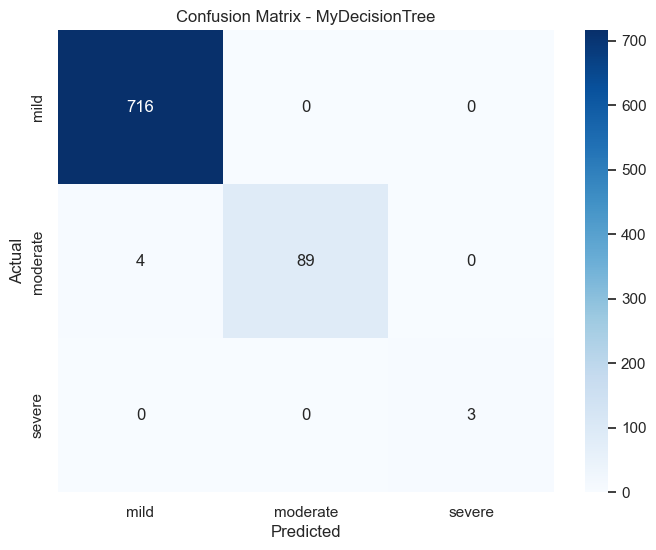

In [21]:
# Ініціалізуємо та навчаємо нашу модель
my_tree = MyDecisionTree(max_depth=5, min_samples_split=10)
my_tree.fit(X_train, y_train)

# Робимо прогнози на тестових даних
y_pred_my_tree = my_tree.predict(X_test)

# Оцінка моделі 
print("--- Оцінка MyDecisionTree (max_depth=5) ---")
accuracy = accuracy_score(y_test, y_pred_my_tree)
f1 = f1_score(y_test, y_pred_my_tree, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred_my_tree)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (Weighted): {f1:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_my_tree, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_my_tree)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - MyDecisionTree')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

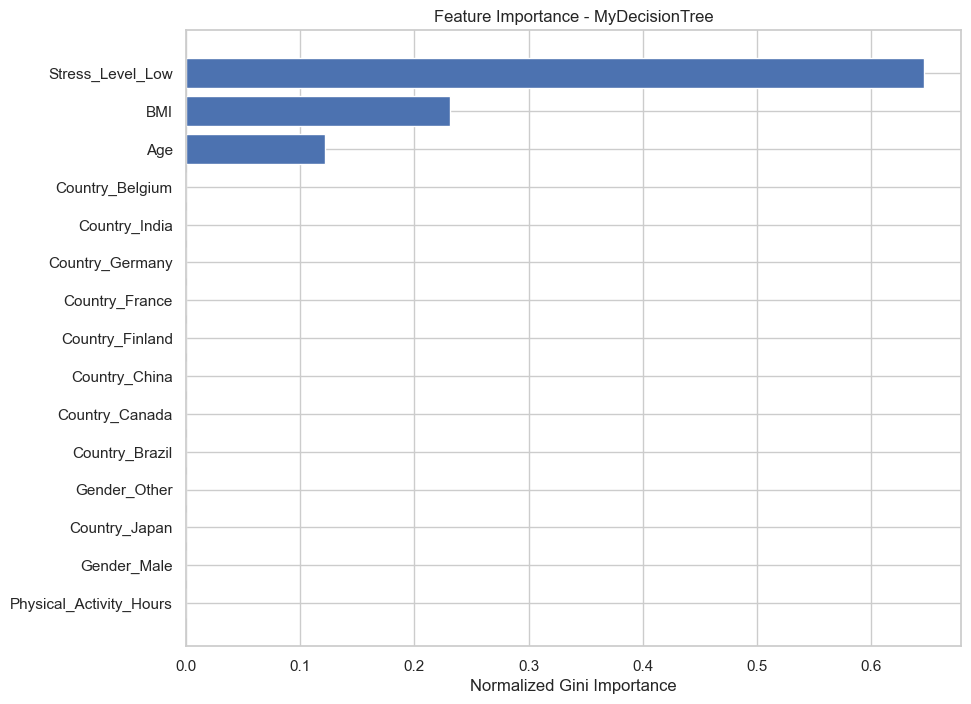

In [22]:
# Візуалізація важливості ознак (Feature Importance) [cite: 9]
importances = my_tree.feature_importance
indices = np.argsort(importances)[-15:] # Топ-15 ознак

plt.figure(figsize=(10, 8))
plt.title('Feature Importance - MyDecisionTree')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Normalized Gini Importance')
plt.show()

Пошук оптимальної max_depth (Pre-pruning)...
Depth: 2, Validation Accuracy: 0.9477
Depth: 2, Validation Accuracy: 0.9477
Depth: 3, Validation Accuracy: 0.9985
Depth: 3, Validation Accuracy: 0.9985
Depth: 4, Validation Accuracy: 0.9985
Depth: 4, Validation Accuracy: 0.9985
Depth: 5, Validation Accuracy: 0.9985
Depth: 5, Validation Accuracy: 0.9985
Depth: 6, Validation Accuracy: 0.9985
Depth: 6, Validation Accuracy: 0.9985
Depth: 7, Validation Accuracy: 0.9985
Depth: 7, Validation Accuracy: 0.9985
Depth: 8, Validation Accuracy: 0.9985
Depth: 8, Validation Accuracy: 0.9985
Depth: 9, Validation Accuracy: 0.9985
Depth: 9, Validation Accuracy: 0.9985
Depth: 10, Validation Accuracy: 0.9985
Depth: 10, Validation Accuracy: 0.9985
Depth: 11, Validation Accuracy: 0.9985
Depth: 11, Validation Accuracy: 0.9985
Depth: 12, Validation Accuracy: 0.9985
Depth: 12, Validation Accuracy: 0.9985
Depth: 13, Validation Accuracy: 0.9985
Depth: 13, Validation Accuracy: 0.9985
Depth: 14, Validation Accuracy: 0.9

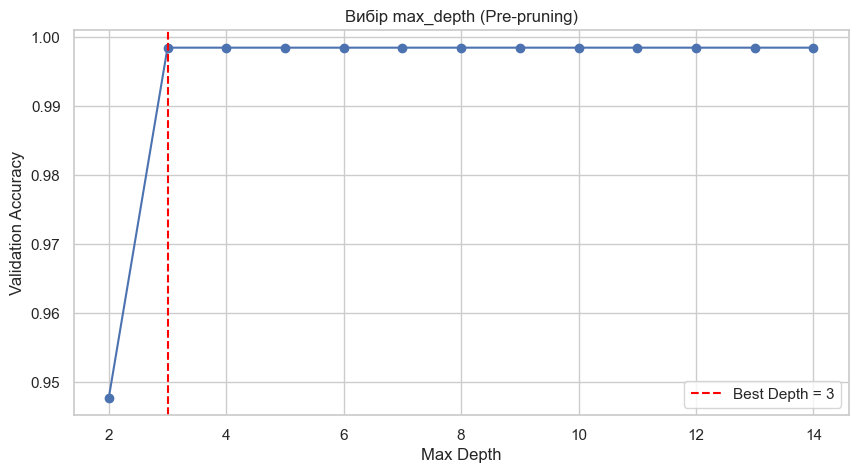

In [23]:
# Розділимо тренувальну вибірку ще раз, щоб отримати валідаційну
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

depths = range(2, 15)
val_accuracies = []

print("Пошук оптимальної max_depth (Pre-pruning)...")
for depth in depths:
    tree = MyDecisionTree(max_depth=depth, min_samples_split=10)
    tree.fit(X_train_sub, y_train_sub)
    y_pred_val = tree.predict(X_val)
    val_accuracies.append(accuracy_score(y_val, y_pred_val))
    print(f"Depth: {depth}, Validation Accuracy: {val_accuracies[-1]:.4f}")

# Знаходимо найкращу глибину
best_depth = depths[np.argmax(val_accuracies)]
print(f"\nОптимальна max_depth: {best_depth}")

# Візуалізуємо вибір глибини
plt.figure(figsize=(10, 5))
plt.plot(depths, val_accuracies, marker='o')
plt.title('Вибір max_depth (Pre-pruning)')
plt.xlabel('Max Depth')
plt.ylabel('Validation Accuracy')
plt.axvline(best_depth, color='red', linestyle='--', label=f'Best Depth = {best_depth}')
plt.legend()
plt.show()

In [24]:
# Навчаємо "обрізану" (оптимізовану) модель на повній тренувальній вибірці
my_tree_pruned = MyDecisionTree(max_depth=best_depth, min_samples_split=10)
my_tree_pruned.fit(X_train, y_train)

# Оцінюємо на тестовій вибірці
y_pred_pruned = my_tree_pruned.predict(X_test)

print(f"--- Оцінка MyDecisionTree (Pruned, max_depth={best_depth}) ---")
accuracy_p = accuracy_score(y_test, y_pred_pruned)
f1_p = f1_score(y_test, y_pred_pruned, average='weighted')
mcc_p = matthews_corrcoef(y_test, y_pred_pruned)

print(f"Accuracy: {accuracy_p:.4f}")
print(f"F1-Score (Weighted): {f1_p:.4f}")
print(f"Matthews Correlation Coefficient (MCC): {mcc_p:.4f}")

# Порівняння з моделлю без прунінгу (max_depth=5)
print(f"\nПокращення Accuracy у порівнянні з (max_depth=5): {accuracy_p - accuracy:.4f}")

--- Оцінка MyDecisionTree (Pruned, max_depth=3) ---
Accuracy: 0.9975
F1-Score (Weighted): 0.9975
Matthews Correlation Coefficient (MCC): 0.9884

Покращення Accuracy у порівнянні з (max_depth=5): 0.0025


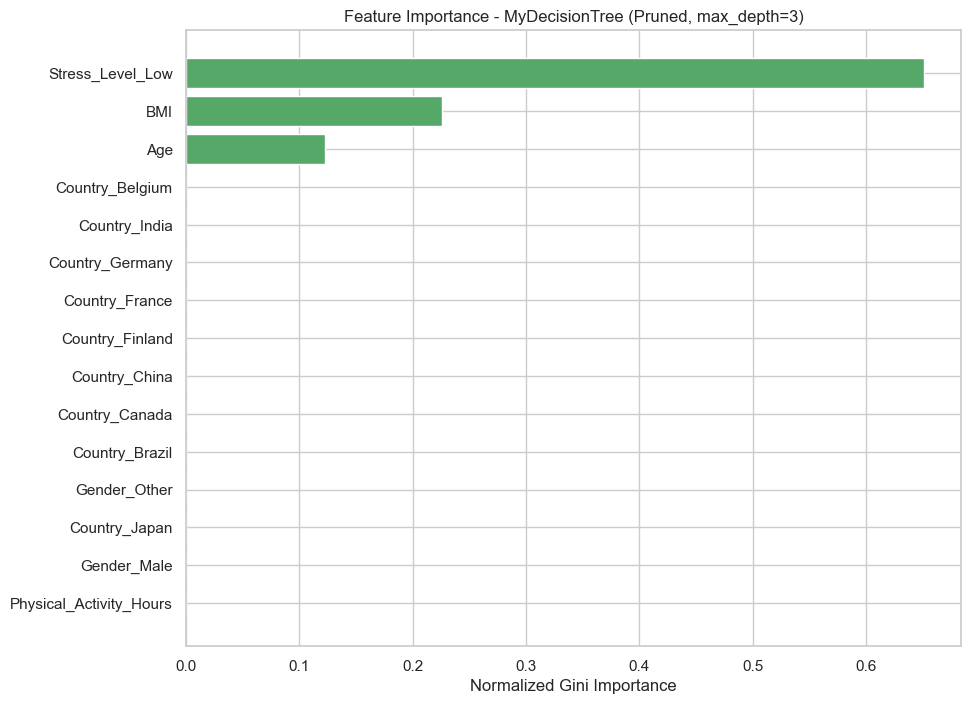

In [25]:
# Переобчислюємо важливість ознак для "обрізаного" дерева [cite: 75]
importances_p = my_tree_pruned.feature_importance
indices_p = np.argsort(importances_p)[-15:]

plt.figure(figsize=(10, 8))
plt.title(f'Feature Importance - MyDecisionTree (Pruned, max_depth={best_depth})')
plt.barh(range(len(indices_p)), importances_p[indices_p], color='g', align='center')
plt.yticks(range(len(indices_p)), [feature_names[i] for i in indices_p])
plt.xlabel('Normalized Gini Importance')
plt.show()

In [26]:
# 1. sklearn Decision Tree Classifier [cite: 113]
# Використовуємо ту саму 'best_depth', що знайшли раніше
dt_sk = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, random_state=42)
dt_sk.fit(X_train, y_train)
y_pred_dt_sk = dt_sk.predict(X_test)

print(f"--- Оцінка sklearn DecisionTree (max_depth={best_depth}) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt_sk):.4f}") # [cite: 126]
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_dt_sk, average='weighted'):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_dt_sk):.4f}")

# 2. sklearn Random Forest Classifier [cite: 114]
rf_sk = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42) # [cite: 127]
rf_sk.fit(X_train, y_train)
y_pred_rf_sk = rf_sk.predict(X_test)

print(f"\n--- Оцінка sklearn Random Forest (n_estimators=100) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf_sk):.4f}") # [cite: 130]
print(f"F1-Score (Weighted): {f1_score(y_test, y_pred_rf_sk, average='weighted'):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred_rf_sk):.4f}")

--- Оцінка sklearn DecisionTree (max_depth=3) ---
Accuracy: 0.9963
F1-Score (Weighted): 0.9963
MCC: 0.9824

--- Оцінка sklearn Random Forest (n_estimators=100) ---
Accuracy: 0.9791
F1-Score (Weighted): 0.9766
MCC: 0.8964

--- Оцінка sklearn Random Forest (n_estimators=100) ---
Accuracy: 0.9791
F1-Score (Weighted): 0.9766
MCC: 0.8964


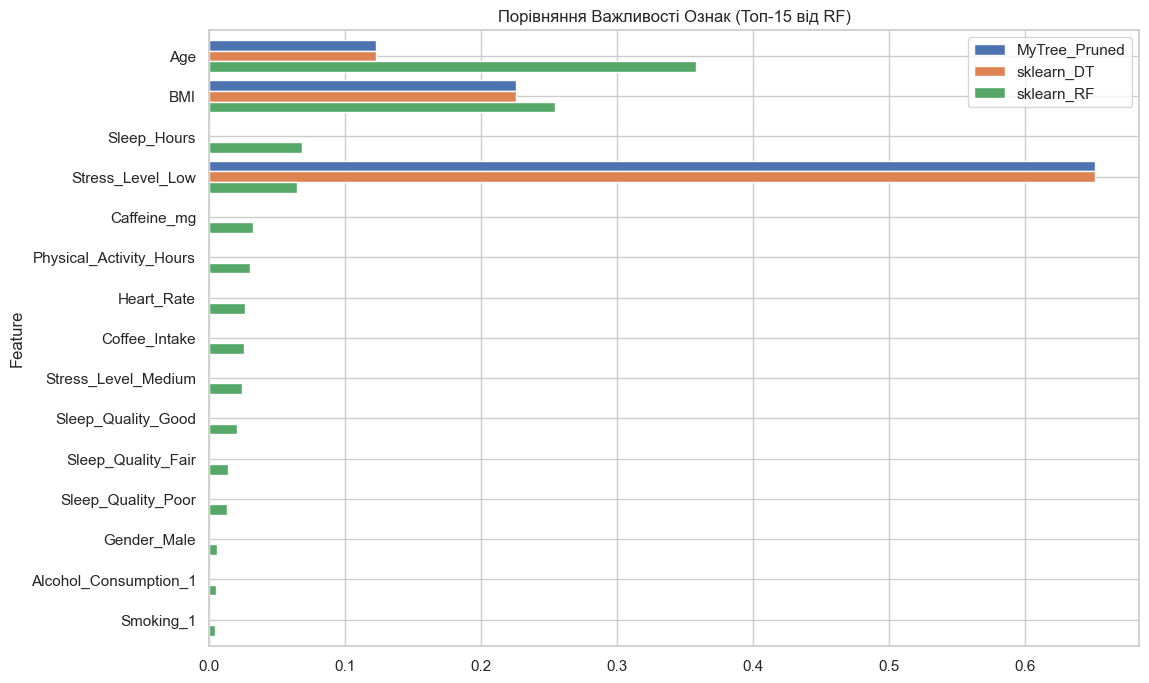

In [27]:
# 3. Порівняння Feature Importance [cite: 106, 116]

# Отримуємо важливості з sklearn моделей
importances_dt_sk = dt_sk.feature_importances_
importances_rf_sk = rf_sk.feature_importances_ # [cite: 106]

# Створюємо DataFrame для зручного порівняння
imp_df = pd.DataFrame({
    'Feature': feature_names,
    'MyTree_Pruned': importances_p,
    'sklearn_DT': importances_dt_sk,
    'sklearn_RF': importances_rf_sk
})

# Сортуємо за важливістю в Random Forest (зазвичай він найнадійніший)
imp_df_sorted = imp_df.sort_values(by='sklearn_RF', ascending=False).head(15)

# Візуалізація [cite: 131]
imp_df_sorted.plot(kind='barh', x='Feature', y=['MyTree_Pruned', 'sklearn_DT', 'sklearn_RF'],
                   figsize=(12, 8), width=0.8)
plt.title('Порівняння Важливості Ознак (Топ-15 від RF)')
plt.gca().invert_yaxis()
plt.show()

In [35]:
# 4. Крос-валідація (5-fold) [cite: 116]

print("\n--- 5-Fold Cross-Validation (Accuracy) ---")

# MyDecisionTree не сумісний зі sklearn.clone, тому робимо ручну Stratified CV для нього
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_my = []
for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    tree_cv = MyDecisionTree(max_depth=best_depth, min_samples_split=10)
    tree_cv.fit(X_tr, y_tr)
    y_pred_cv = tree_cv.predict(X_val)
    cv_scores_my.append(accuracy_score(y_val, y_pred_cv))
print(f"MyDecisionTree (Pruned, manual 5-fold): {np.mean(cv_scores_my):.4f} +/- {np.std(cv_scores_my):.4f}")

# Для sklearn-моделей можна використовувати готову cross_val_score (вона користується clone)
cv_dt_sk = cross_val_score(dt_sk, X_train, y_train, cv=5, scoring='accuracy')
print(f"sklearn DecisionTree: {np.mean(cv_dt_sk):.4f} +/- {np.std(cv_dt_sk):.4f}")

cv_rf_sk = cross_val_score(rf_sk, X_train, y_train, cv=5, scoring='accuracy')
print(f"sklearn Random Forest: {np.mean(cv_rf_sk):.4f} +/- {np.std(cv_rf_sk):.4f}")


--- 5-Fold Cross-Validation (Accuracy) ---
MyDecisionTree (Pruned, manual 5-fold): 0.9978 +/- 0.0016
sklearn DecisionTree: 0.9975 +/- 0.0016
MyDecisionTree (Pruned, manual 5-fold): 0.9978 +/- 0.0016
sklearn DecisionTree: 0.9975 +/- 0.0016
sklearn Random Forest: 0.9868 +/- 0.0040
sklearn Random Forest: 0.9868 +/- 0.0040


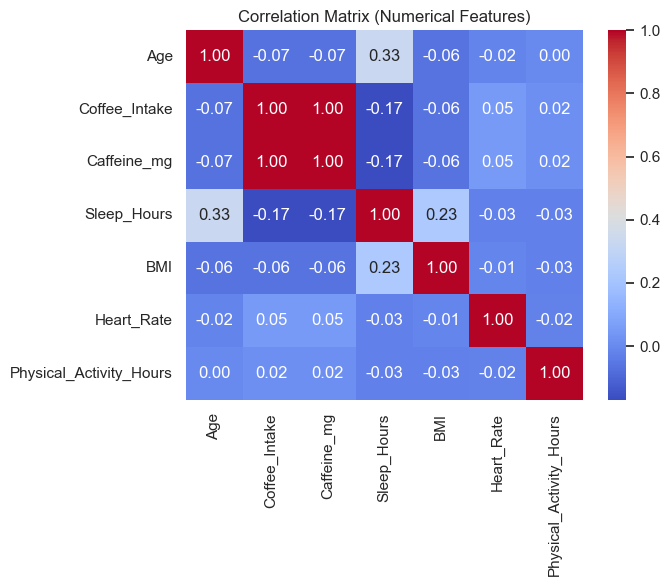

Видалено ознаку 'Caffeine_mg' через високу кореляцію з 'Coffee_Intake'.


In [29]:
# 1. Повертаємось до оригінальних X та y (до one-hot encoding)
X = data.drop(TARGET_VAR, axis=1)
y = data[TARGET_VAR]
y_encoded = le.transform(y) # Використовуємо той самий енкодер

# 2. Інженерія Ознак (Feature Engineering) [cite: 141, 142]

# 2.1 Створення взаємодій [cite: 157]
X_fe = X.copy()
X_fe['Coffee_Sleep_Interaction'] = X_fe['Coffee_Intake'] * X_fe['Sleep_Hours'] # [cite: 159]

# 2.2 Бінінг (Binning) [cite: 158]
X_fe['Age_Binned'] = pd.cut(X_fe['Age'], bins=[18, 30, 50, 80],
                           labels=['Young', 'Middle', 'Old'], right=False)

# 2.3 Аналіз кореляцій (для видалення) 
corr_matrix = X_fe[['Age', 'Coffee_Intake', 'Caffeine_mg', 'Sleep_Hours', 'BMI', 'Heart_Rate', 'Physical_Activity_Hours']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

# Бачимо високу кореляцію між 'Coffee_Intake' та 'Caffeine_mg'.
# Видалимо 'Caffeine_mg', щоб уникнути мультиколінеарності.
X_fe = X_fe.drop('Caffeine_mg', axis=1)
print("Видалено ознаку 'Caffeine_mg' через високу кореляцію з 'Coffee_Intake'.")

# 2.4 Кодування нових категоріальних ознак [cite: 161, 162]
cat_cols_fe = ['Gender', 'Country', 'Sleep_Quality', 'Stress_Level', 
               'Occupation', 'Smoking', 'Alcohol_Consumption', 'Age_Binned']
X_fe_processed = pd.get_dummies(X_fe, columns=cat_cols_fe, drop_first=True)

# 2.5 Нормалізація (Z-score) [cite: 142, 163]
# (Дерева рішень нечутливі до масштабування, але це гарна практика
# для інших моделей і не зашкодить деревам)
from sklearn.preprocessing import StandardScaler

num_cols_fe = ['Age', 'Coffee_Intake', 'Sleep_Hours', 'BMI', 'Heart_Rate',
               'Physical_Activity_Hours', 'Coffee_Sleep_Interaction']
scaler = StandardScaler() # [cite: 164]
X_fe_processed[num_cols_fe] = scaler.fit_transform(X_fe_processed[num_cols_fe]) # [cite: 167]

# Зберігаємо нові імена ознак
feature_names_fe = X_fe_processed.columns.tolist()

In [30]:
# 3. Feature Selection (Відбір Ознак) [cite: 143]

# 3.1 Поділ нового датасету
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe_processed.values,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# 3.2 Навчаємо MyDecisionTree на новому датасеті, щоб отримати importance [cite: 170]
# Використовуємо 'best_depth', знайдений раніше
tree_for_selection = MyDecisionTree(max_depth=best_depth, min_samples_split=10)
tree_for_selection.fit(X_train_fe, y_train_fe)

importances_fe = tree_for_selection.feature_importance # [cite: 172]

# 3.3 Відбір Топ-K ознак [cite: 144]
K = 20 # Обираємо топ-20 ознак
selected_indices = np.argsort(importances_fe)[-K:] # [cite: 174]
selected_features = [feature_names_fe[i] for i in selected_indices]

print(f"\nТоп-{K} відібраних ознак:")
print(selected_features)

# 3.4 Створюємо нові вибірки з відібраними ознаками [cite: 175]
X_train_selected = X_train_fe[:, selected_indices]
X_test_selected = X_test_fe[:, selected_indices]


Топ-20 відібраних ознак:
['Coffee_Intake', 'Sleep_Hours', 'Heart_Rate', 'Physical_Activity_Hours', 'Coffee_Sleep_Interaction', 'Gender_Male', 'Country_Mexico', 'Country_Belgium', 'Gender_Other', 'Country_Canada', 'Country_China', 'Country_Finland', 'Country_France', 'Country_Germany', 'Country_India', 'Country_Italy', 'Country_Brazil', 'Age', 'BMI', 'Stress_Level_Low']


In [31]:
# 4. Повторне навчання та оцінка на відібраних ознаках 

print("\n--- Оцінка моделей на ВІДІБРАНИХ ОЗНАКАХ ---")

# 4.1 MyDecisionTree (Pruned)
my_tree_final = MyDecisionTree(max_depth=best_depth, min_samples_split=10)
my_tree_final.fit(X_train_selected, y_train_fe)
y_pred_final_my_tree = my_tree_final.predict(X_test_selected)
print(f"MyDecisionTree (Selected): Accuracy={accuracy_score(y_test_fe, y_pred_final_my_tree):.4f}")

# 4.2 sklearn DecisionTree
dt_sk_final = DecisionTreeClassifier(criterion='gini', max_depth=best_depth, random_state=42)
dt_sk_final.fit(X_train_selected, y_train_fe)
y_pred_final_dt_sk = dt_sk_final.predict(X_test_selected)
print(f"sklearn DT (Selected): Accuracy={accuracy_score(y_test_fe, y_pred_final_dt_sk):.4f}")

# 4.3 sklearn Random Forest
rf_sk_final = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
rf_sk_final.fit(X_train_selected, y_train_fe)
y_pred_final_rf_sk = rf_sk_final.predict(X_test_selected)
print(f"Random Forest (Selected): Accuracy={accuracy_score(y_test_fe, y_pred_final_rf_sk):.4f}")


--- Оцінка моделей на ВІДІБРАНИХ ОЗНАКАХ ---
MyDecisionTree (Selected): Accuracy=0.9975
sklearn DT (Selected): Accuracy=0.9963
Random Forest (Selected): Accuracy=0.9926
MyDecisionTree (Selected): Accuracy=0.9975
sklearn DT (Selected): Accuracy=0.9963
Random Forest (Selected): Accuracy=0.9926



Розрахунок Permutation Importance...


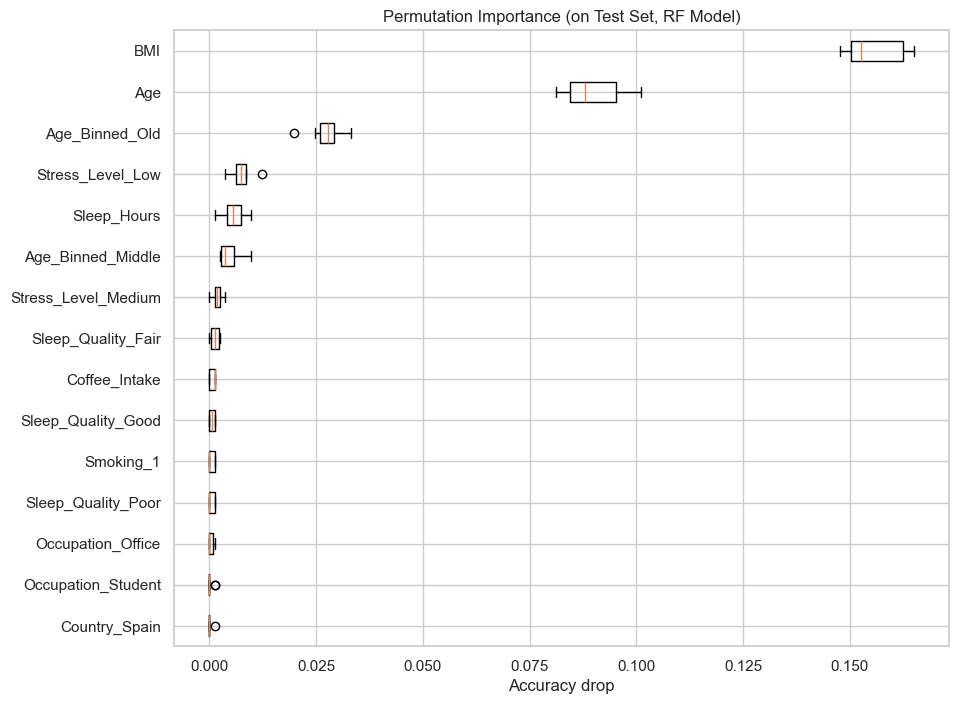

In [32]:
# 5. Permutation Importance (на RF моделі) 
# Використовуємо модель, навчену на всіх інженерних ознаках, для повноти
rf_fe = RandomForestClassifier(n_estimators=100, random_state=42).fit(X_train_fe, y_train_fe)

print("\nРозрахунок Permutation Importance...")
perm_imp = permutation_importance(
    rf_fe, X_test_fe, y_test_fe, n_repeats=10, random_state=42, n_jobs=-1
) # [cite: 177]

# Відображення Permutation Importance
sorted_idx = perm_imp.importances_mean.argsort()[-15:] # Топ-15
plt.figure(figsize=(10, 8))
plt.boxplot(perm_imp.importances[sorted_idx].T, vert=False,
            labels=[feature_names_fe[i] for i in sorted_idx])
plt.title("Permutation Importance (on Test Set, RF Model)")
plt.xlabel("Accuracy drop")
plt.show()